<a href="https://colab.research.google.com/github/young-hwanlee/my-practical-statistics-for-data-scientists/blob/main/Chapter_7_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Clone the repository
# !git clone https://github.com/young-hwanlee/practical-statistics-for-data-scientists.git

# # Open the file from the list of contents (File)
# # Then, copy and paste it

## Practical Statistics for Data Scientists (Python)
## Chapter 7. Unsupervised Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [2]:
!pip install prince

In [3]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline
print()

In [4]:
# try:
#     import common
#     DATA = common.dataDirectory()
# except ImportError:
#     DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [5]:
# SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
# SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
# LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
# HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

DATA = 'https://raw.githubusercontent.com/young-hwanlee/practical-statistics-for-data-scientists/master/data/'

SP500_DATA_CSV = DATA + 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA + 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA + 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA + 'housetasks.csv'

## **7.1 Principal Components Analysis**
### **7.1.1 A Simple Example**

In [6]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [7]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


In [8]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

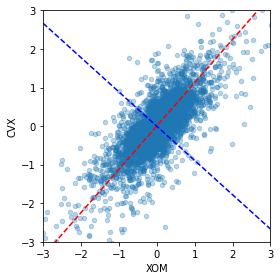

In [9]:
ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
#         '--', color='C1')
# ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
#         '--', color='C1)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='r')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='b')

plt.tight_layout()
plt.show()

### **7.1.3 Interpreting Principal Components**

In [10]:
sp500_px

,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,ALTR,ADI,AVGO,BRCM,FSLR,INTC,LLTC,MCHP,MU,NVDA,QRVO,QCOM,SWKS,TXN,XLNX,AAPL,HPQ,EA,SNDK,STX,WDC,TEL,HRS,MSI,ACN,AMAT,KLAC,LRCX,ADBE,ADSK,ORCL,...,ENDP,LLY,MNK,MRK,MYL,PRGO,PFE,ZTS,ABT,A,BCR,BAX,BDX,BSX,EW,HSP,ISRG,JNJ,MDT,PKI,STJ,SYK,TMO,VAR,ZBH,BMY,CAH,CERN,ESRX,MCK,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
1993-01-29,0.000000,0.060124,-0.022100,0.000000,0.000000,0.018897,0.007368,0.092165,0.259140,-0.007105,-0.015785,0.000000,0.000000,0.000000,-0.050488,-0.089870,0.000000,0.037021,0.000000,0.000000,-0.044718,-0.041262,0.060179,0.033152,-0.024235,0.045586,0.125000,0.000000,0.000000,0.118103,0.000000,0.016412,-1.842719,0.000000,-0.012867,0.079940,0.246706,-0.044884,0.057267,-0.005776,...,0.000000,-0.077535,0.000000,-0.028797,0.166355,-0.577943,0.066591,0.000000,0.045961,0.000000,-0.326659,0.000000,-0.033363,0.062500,0.000000,0.000000,0.000000,0.018827,0.006047,0.000000,0.187132,0.276317,-0.124187,0.037430,0.000000,0.038546,0.060142,0.031260,0.001950,0.000000,0.000000,0.000000,0.347160,0.000000,0.041670,0.000000,0.015564,1.750000,0.125000,0.000000
1993-02-01,0.000000,-0.180389,0.027621,0.000000,0.000000,0.018889,0.018425,0.115207,-0.100775,0.063893,-0.015793,0.000000,0.000000,0.000000,0.095367,0.044935,0.000000,0.037020,0.000000,0.000000,0.006387,-0.041252,0.102317,0.099446,0.064618,0.072942,0.093750,0.000000,0.000000,0.000000,0.000000,-0.032829,0.594428,0.000000,0.016077,0.019985,0.411170,0.134672,0.057267,0.025999,...,0.000000,-0.031014,0.000000,-0.172781,-0.066536,0.346766,-0.027745,0.000000,-0.045960,0.000000,-0.093331,0.018157,0.100076,0.031250,0.000000,0.000000,0.000000,-0.056481,-0.048392,0.041782,-0.074851,-0.027632,0.000000,-0.074859,0.000000,-0.038546,0.060142,0.101560,0.019530,0.000000,0.000000,0.000000,-0.231440,0.000000,0.000000,-0.010410,0.007782,1.250000,0.125000,0.000000
1993-02-02,0.000000,-0.120257,0.035900,0.000000,0.000000,-0.075573,0.029482,-0.023041,0.028796,-0.014192,0.047363,0.000000,0.000000,0.000000,0.000000,0.067402,0.000000,0.123402,0.000000,0.000000,0.035141,0.041252,-0.024066,0.016572,-0.016148,-0.045586,-0.062500,0.000000,0.000000,0.118103,0.000000,-0.032829,0.237767,0.000000,0.051450,0.000000,0.054828,0.082299,-0.042955,-0.011562,...,0.000000,-0.062028,0.000000,-0.143984,-0.066536,0.693532,-0.133183,0.000000,-0.153198,0.000000,-0.093331,-0.072626,0.000000,0.031250,0.000000,0.000000,0.000000,-0.018827,0.000000,0.208912,0.018711,-0.027632,0.000000,0.044923,0.000000,-0.115639,-0.030071,-0.015620,0.000000,0.000000,0.000000,0.000000,-0.115720,0.000000,0.000000,0.000000,-0.007792,-0.250000,0.000000,0.000000
1993-02-03,0.000000,0.060124,-0.024857,0.000000,0.000000,-0.151128,0.003689,-0.253454,-0.043190,-0.007105,0.205236,0.000000,0.000000,0.000000,-0.050495,0.022467,0.000000,-0.012340,0.000000,0.000000,0.006387,0.041252,-0.024073,0.049723,-0.032305,-0.091184,0.218750,0.000000,0.000000,0.059052,0.000000,0.049247,-0.118893,0.000000,0.000000,0.039970,-0.054828,-0.149639,0.057267,0.002884,...,0.000000,0.139564,0.000000,0.345561,0.133081,0.693532,0.022199,0.000000,0.168520,0.000000,0.093331,0.090783,0.044480,0.031250,0.000000,0.000000,0.000000,0.263578,0.030243,0.125347,0.187140,0.000000,0.124187,0.104805,0.000000,0.141333,0.000000,-0.011720,0.023440,0.000000,0.000000,0.000000,-0.086790,0.000000,0.041670,-0.041670,-0.038919,-0.500000,0.062500,0.000000
1993-02-04,0.000000,-0.360770,-0.060757,0.000000,0.000000,0.113350,-0.022114,0.069862,0.000000,-0.007096,-0.031570,0.000000,0.000000,0.000000,0.000000,0.022467,0.000000,-0.074041,0.000000,0.000000,0.051113,0.041252,-0.024073,-0.008290,-0.016157,-0.109414,0.093750,0.000000,0.000000,-0.118103,0.000000,0.000000,-0.237776,0.000000,-0.003219,-0.099925,-0.246706,0.000000,-0.157480,-0.017329,...,0.000000,0.000000,0.000000,-0.345561,-0.133073,-0.924709,-0.016648,0.000000,-0.061282,0.000000,0.186662,0.000000,-0.011123,-0.156250,0.000000,0.000000,0.000000,0.018827,-0.024196,0.167129,-0.187629,-0.082895,0.341510,-0.029946,0.000

In [11]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
top_sp

,AAPL,AXP,COP,COST,CSCO,CVX,HD,INTC,JPM,MSFT,SLB,TGT,USB,WFC,WMT,XOM
2011-01-03,0.527368,0.093870,-0.336272,-0.240605,0.035704,0.240681,0.099184,-0.137211,0.512093,-0.061805,-0.325923,0.455646,-0.234866,0.250042,0.294839,0.736805
2011-01-04,-0.154321,-0.431788,-0.463161,-0.171859,0.008926,-0.584516,-0.541005,0.025726,0.335894,0.132440,-2.030049,-0.580720,-0.153566,0.000000,0.142951,0.168668
2011-01-05,0.597152,0.895406,-0.057104,-0.859307,0.169599,0.446985,-0.054099,-0.214392,0.689468,0.088294,1.536499,-0.482448,0.198732,0.857284,-0.303772,0.026631
2011-01-06,-0.132850,-0.612646,-0.463161,0.249200,0.035706,-0.919751,-0.189354,0.085757,0.070713,0.688689,-1.927614,-0.786210,-0.532962,0.000000,-0.312709,0.248558
2011-01-07,0.285820,-0.537242,-0.006350,-0.257788,0.098187,0.180511,-0.036064,-0.042878,-0.795539,-0.035317,0.931215,-0.089345,-0.171633,-0.651894,0.169758,0.337329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-25,-1.360001,-1.105863,-0.949997,-1.000000,-0.158775,-1.110001,-1.000000,-0.030000,-0.665647,-0.379997,-0.690003,0.080002,-0.238625,-0.580002,-0.589996,-0.919998
2015-06-26,-0.919998,-0.288920,0.029998,0.119996,-0.208393,0.360000,-0.169999,-0.490000,0.009930,-0.390004,0.279999,-0.409996,-0.020001,0.099999,0.160004,0.029999
2015-06-29,-0.930000,-1.414705,-0.410000,-1.319993,-0.446558,-0.809998,-1.019997,-0.310002,-0.476886,-0.670002,0.060006,-1.390007,-0.500000,-0.739998,-0.380005,-0.230003
2015-06-30,-0.140000,-0.449997,-0.119999,-1.320007,-0.367171,-0.979996,-0.020005,-0.209999,-0.129153,-0.559997,-0.189995,-1.020005,-0.439998,-0.299999,-0.879998,-0.540001


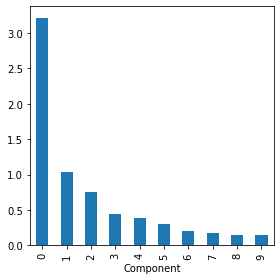

In [12]:
sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

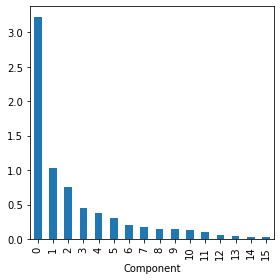

In [13]:
ax = explained_variance.plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [14]:
sp_pca

PCA()

In [15]:
np.shape(sp_pca.components_)

(16, 16)

In [16]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP  ...       WFC       WMT       XOM
0 -0.300825 -0.246332 -0.261529  ... -0.145684 -0.122304 -0.317952
1 -0.505116 -0.139426  0.174212  ... -0.047427 -0.222889  0.154192
2 -0.786730  0.135458 -0.002367  ...  0.041932  0.175806  0.090167
3 -0.120586  0.061814 -0.206026  ...  0.018614  0.058439 -0.295204
4  0.111576 -0.596666 -0.005813  ... -0.216425  0.091541  0.013277

[5 rows x 16 columns]


In [17]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5, :])))
print(maxPC)

0.7945969308281738


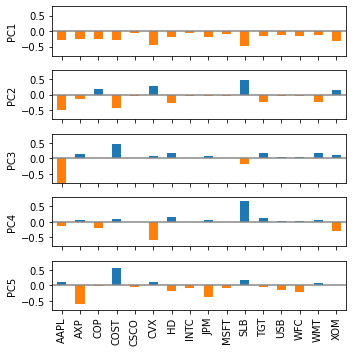

In [18]:
f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

# Matplotlib converts "CN" colors to RGBA when drawing Artists. The Styling with cycler section
# contains additional information about controlling colors and style properties.
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

### **7.1.4 Correspondence Analysis**

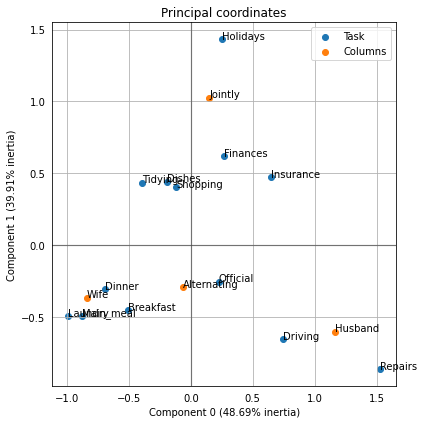

In [19]:
housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(6, 6))
plt.tight_layout()
plt.show()

https://oreil.ly/yVryf

## **7.2 K-Means Clustering**
### **7.2.1 A Simple Example**

In [20]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)

In [21]:
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        0
2011-01-04  0.168668 -0.584516        3
2011-01-05  0.026631  0.446985        0
2011-01-06  0.248558 -0.919751        3
2011-01-07  0.337329  0.180511        0


In [22]:
df.head(10)

,XOM,CVX,cluster
2011-01-03,0.736805,0.240681,0
2011-01-04,0.168668,-0.584516,3
2011-01-05,0.026631,0.446985,0
2011-01-06,0.248558,-0.919751,3
2011-01-07,0.337329,0.180511,0
2011-01-10,0.000000,-0.464168,3
2011-01-11,0.594773,0.825197,0
2011-01-12,0.568137,0.077359,0
2011-01-13,0.053260,0.146127,0
2011-01-14,1.038624,0.610301,2


In [23]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
# print(centers)
centers

,XOM,CVX
0,0.243415,0.337513
1,-1.137958,-1.746642
2,0.962633,1.379702
3,-0.328125,-0.564848


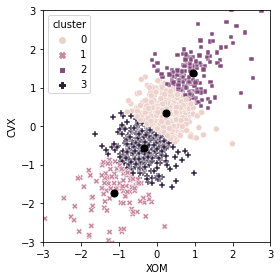

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

### **7.2.2 K-Means Algorithm**
The _scikit-learn_ algorithm is repeated 10 times by default (`n_init=10`), `max_iter (=300)` is used to control the number of iterations.

In [25]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

In [26]:
set(kmeans.labels_)

{0, 1, 2, 3, 4}

### **7.2.3 Interpreting the Clusters**

In [27]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({4: 290, 0: 283, 2: 271, 3: 176, 1: 111})


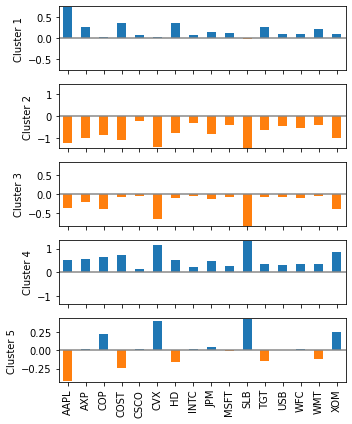

In [28]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

### **7.2.4 Selecting the Number of Clusters**

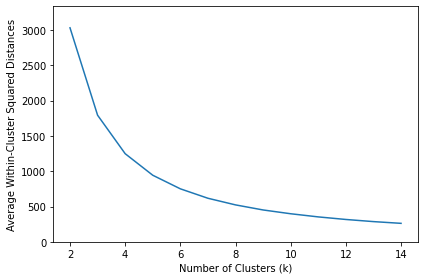

In [29]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})

ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

https://hastie.su.domains/Papers/gap.pdf

## **7.3 Hierarchical Clustering**
### **7.3.1 A Simple Example**

In [30]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


In [31]:
df

,2011-01-03,2011-01-04,2011-01-05,2011-01-06,2011-01-07,2011-01-10,2011-01-11,2011-01-12,2011-01-13,2011-01-14,2011-01-18,2011-01-19,2011-01-20,2011-01-21,2011-01-24,2011-01-25,2011-01-26,2011-01-27,2011-01-28,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-07,2011-02-08,2011-02-09,2011-02-10,2011-02-11,2011-02-14,2011-02-15,2011-02-16,2011-02-17,2011-02-18,2011-02-22,2011-02-23,2011-02-24,2011-02-25,2011-02-28,2011-03-01,...,2015-05-06,2015-05-07,2015-05-08,2015-05-11,2015-05-12,2015-05-13,2015-05-14,2015-05-15,2015-05-18,2015-05-19,2015-05-20,2015-05-21,2015-05-22,2015-05-26,2015-05-27,2015-05-28,2015-05-29,2015-06-01,2015-06-02,2015-06-03,2015-06-04,2015-06-05,2015-06-08,2015-06-09,2015-06-10,2015-06-11,2015-06-12,2015-06-15,2015-06-16,2015-06-17,2015-06-18,2015-06-19,2015-06-22,2015-06-23,2015-06-24,2015-06-25,2015-06-26,2015-06-29,2015-06-30,2015-07-01
AAPL,0.527368,-0.154321,0.597152,-0.132850,0.285820,0.485766,-0.434780,0.157012,0.069781,0.347552,1.493539,-1.276160,-0.503220,-0.946041,1.419738,0.680352,0.119427,-0.076492,-1.082911,0.472350,0.500533,-0.017447,-0.048310,0.383783,0.535419,0.203974,0.398542,-0.382439,0.281799,0.320717,0.095279,0.312658,0.140901,-1.093654,-0.475031,0.516632,-0.152970,0.389147,0.264356,-0.826614,...,-1.543548,0.490005,0.940003,-1.069999,0.270005,-0.140000,1.539993,-0.300003,1.809997,-0.619995,0.059998,1.319992,0.939987,-2.980011,1.699997,-0.080002,-0.949997,0.259994,0.100006,-0.540009,-0.220001,-0.850006,-1.099991,0.720001,0.960007,-0.589997,-1.020004,0.820000,0.569999,-0.419998,0.649994,-1.110001,0.120003,-0.450004,0.900002,-1.360001,-0.919998,-0.930000,-0.140000,-0.300004
AMZN,2.850006,-1.139999,3.319992,-0.639999,-2.390000,-0.360000,-1.080002,-1.279999,1.929993,3.250000,2.589996,-4.029999,-3.329986,-5.580002,-1.099991,1.199997,-2.119996,6.970001,-0.309998,-0.520005,1.589997,2.110001,0.210007,1.929993,0.279999,6.399994,2.150009,1.820008,3.690002,1.169998,0.300003,-3.150009,1.989991,-1.039993,-3.259995,-3.570007,0.889999,-1.709992,-0.620011,-4.089997,...,-2.329987,2.730011,2.940002,0.339996,-0.059998,-3.110016,2.829987,-2.000000,-0.760010,-3.160004,3.259979,3.630005,-3.919983,-0.730011,3.970001,-3.139984,2.000000,0.520019,0.919983,2.190002,-3.619995,-2.709992,-2.119995,2.520020,4.309998,0.679992,-1.329987,-3.989991,3.110016,-0.549987,9.090027,-5.339997,-0.709991,10.399994,-4.130005,2.029999,-3.660004,-5.120026,-0.110016,-1.959991
AXP,0.093870,-0.431788,0.895406,-0.612646,-0.537242,0.245056,0.056553,-0.414713,0.235633,1.244141,0.320461,0.037702,0.499540,0.226209,-0.245056,-0.065977,-0.424140,0.047126,-0.650345,-0.706898,0.056549,0.311037,-0.113107,0.273335,0.810578,1.149889,0.113107,0.857703,0.452415,0.094255,-0.292186,0.414717,-0.725749,-0.065976,-0.612643,-0.716326,0.263911,-0.056553,-0.150805,-0.518391,...,-0.846831,0.587805,0.089669,0.647571,-0.069739,0.358659,0.408476,-0.677466,-0.109591,0.986308,-0.448328,0.219181,0.408476,-0.926534,-0.338729,0.119548,-0.318807,-0.468249,0.727275,0.278954,-0.687430,-0.348694,-0.617691,0.288920,0.986315,-0.039844,-0.896646,0.249068,0.318807,0.677466,0.528023,-0.328765,0.567875,-0.079703,-0.199258,-1.105863,-0.288920,-1.414705,-0.449997,-0.239997
COP,-0.336272,-0.463161,-0.057104,-0.463161,-0.006350,0.095172,0.380682,0.038061,-0.704260,0.279170,0.107859,-0.323578,-0.183998,-0.139587,0.215721,-0.310894,0.767708,-0.012688,0.532959,0.107856,0.057105,0.298203,-0.063445,-0.222062,0.367989,-0.158617,-0.672533,-0.012691,1.084943,1.148390,-0.107856,0.551996,0.640108,0.428870,-0.640111,1.043369,-1.043379,-0.019203,0.377668,-0.300849,...,-0.721813,-0.899795,0.029663,-1.819377,0.108768,-0.405408,-0.118658,0.504285,0.286750,-0.622935,0.029999,0.450005,0.070000,-0.730000,-0.119999,0.330002,-0.020001,-0.849998,0.369999,-0.010002,-0.410000,0.280003,0.510002,-0.719998,0.109997,0.059998,-0.250000,0.189998,-0.009999,-0.790001,-0.220002,-0.200001,0.100002,0.489998,-0.299999,-0.949997,0.029998,-0.410000,-0.119999,-1.479999
COST,-0.240605,-0.171859,-0.859307,0.

In [32]:
Z

array([[ 14.        ,  15.        ,   8.59490731,   2.        ],
       [  5.        ,   9.        ,   8.70726095,   2.        ],
       [ 11.        ,  19.        ,  11.43861911,   3.        ],
       [ 18.        ,  20.        ,  13.54055199,   5.        ],
       [ 10.        ,  21.        ,  17.54262662,   6.        ],
       [ 13.        ,  16.        ,  18.30670621,   2.        ],
       [  3.        ,  17.        ,  18.96087019,   2.        ],
       [ 22.        ,  23.        ,  21.31534597,   8.        ],
       [  6.        ,  24.        ,  22.85872694,   3.        ],
       [  2.        ,  25.        ,  24.02785309,   9.        ],
       [  8.        ,  27.        ,  25.49676797,  10.        ],
       [  4.        ,  28.        ,  29.1889513 ,  11.        ],
       [ 12.        ,  26.        ,  31.15301738,   4.        ],
       [  0.        ,  29.        ,  38.98012839,  12.        ],
       [ 30.        ,  31.        ,  43.24155434,  16.        ],
       [  1.        ,  32

### **7.3.2 The Dendrogram**

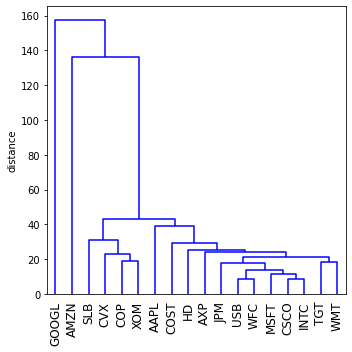

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

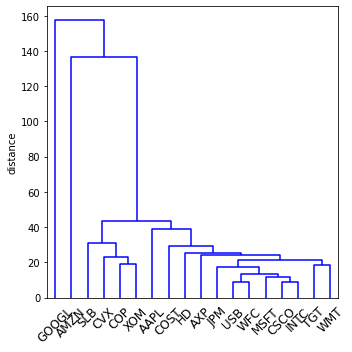

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=45)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [35]:
memb = fcluster(Z, 4, criterion='maxclust')
memb

array([2, 3, 2, 1, 2, 2, 1, 4, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1], dtype=int32)

In [36]:
memb = pd.Series(memb, index=df.index)
memb

AAPL     2
AMZN     3
AXP      2
COP      1
COST     2
CSCO     2
CVX      1
GOOGL    4
HD       2
INTC     2
JPM      2
MSFT     2
SLB      1
TGT      2
USB      2
WFC      2
WMT      2
XOM      1
dtype: int32

In [37]:
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


### **7.3.4 Measures of Dissimilarity**

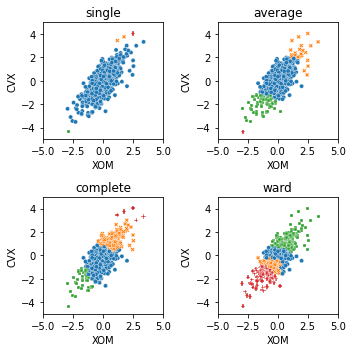

In [38]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    # ax.set_xlim(-3, 3)
    # ax.set_ylim(-3, 3)

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    ax.set_title(method)

plt.tight_layout()
plt.show()

## **7.4 Model based clustering**
### **7.4.1 Multivariate Normal Distribution**
Define a colormap that corresponds to the probability levels.

In [39]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]

def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]
levels

[0.07957747154594767,
 0.039788735772973836,
 0.007957747154594774,
 0.0015915494309189549]

[[-2.8  -2.8  -2.8  ... -2.8  -2.8  -2.8 ]
 [-2.79 -2.79 -2.79 ... -2.79 -2.79 -2.79]
 [-2.78 -2.78 -2.78 ... -2.78 -2.78 -2.78]
 ...
 [ 3.77  3.77  3.77 ...  3.77  3.77  3.77]
 [ 3.78  3.78  3.78 ...  3.78  3.78  3.78]
 [ 3.79  3.79  3.79 ...  3.79  3.79  3.79]]
(660, 900)

[[-5.   -4.99 -4.98 ...  3.97  3.98  3.99]
 [-5.   -4.99 -4.98 ...  3.97  3.98  3.99]
 [-5.   -4.99 -4.98 ...  3.97  3.98  3.99]
 ...
 [-5.   -4.99 -4.98 ...  3.97  3.98  3.99]
 [-5.   -4.99 -4.98 ...  3.97  3.98  3.99]
 [-5.   -4.99 -4.98 ...  3.97  3.98  3.99]]
(660, 900)

[[[-5.00000000e+000 -4.99000000e+000]
  [-4.98000000e+000 -4.97000000e+000]
  [-4.96000000e+000 -4.95000000e+000]
  ...
  [ 3.94000000e+000  3.95000000e+000]
  [ 3.96000000e+000  3.97000000e+000]
  [ 3.98000000e+000  3.99000000e+000]]

 [[-5.00000000e+000 -4.99000000e+000]
  [-4.98000000e+000 -4.97000000e+000]
  [-4.96000000e+000 -4.95000000e+000]
  ...
  [ 3.94000000e+000  3.95000000e+000]
  [ 3.96000000e+000  3.97000000e+000]
  [ 3.98000000e+

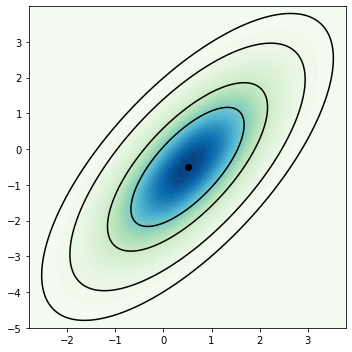

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
print(x)
print(x.shape)
print('')

print(y)
print(y.shape)
print('')

pos = np.empty(x.shape + (2,))
print(pos)
print(pos.shape)
print('')

print(np.empty(x.shape))
print(np.empty(x.shape).shape)

pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)

CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')

plt.tight_layout()
plt.show()

### **7.4.2 Mixtures of Normals**

In [41]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))   # Bayesian information criterion for the current model on the input "df"

4589.8206262498725


In [42]:
df

,XOM,CVX
2011-01-03,0.736805,0.240681
2011-01-04,0.168668,-0.584516
2011-01-05,0.026631,0.446985
2011-01-06,0.248558,-0.919751
2011-01-07,0.337329,0.180511
...,...,...
2015-06-25,-0.919998,-1.110001
2015-06-26,0.029999,0.360000
2015-06-29,-0.230003,-0.809998
2015-06-30,-0.540001,-0.979996


In [43]:
mclust.predict(df)

array([1, 1, 1, ..., 1, 1, 0])

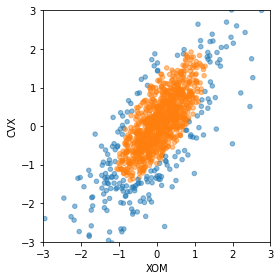

In [44]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [45]:
print('Mean')
print(mclust.means_)
print('')
print('Covariances')
print(mclust.covariances_)

Mean
[[-0.05050178 -0.21237957]
 [ 0.07225117  0.10452744]]

Covariances
[[[0.97385279 0.98028909]
  [0.98028909 1.67646834]]

 [[0.26868436 0.27606914]
  [0.27606914 0.51762673]]]


### **7.4.3 Selecting the number of clusters**

In [46]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

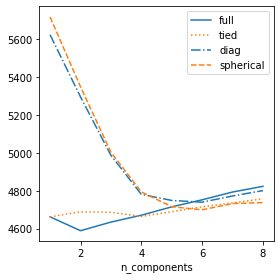

In [47]:
colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-', 'C1:', 'C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

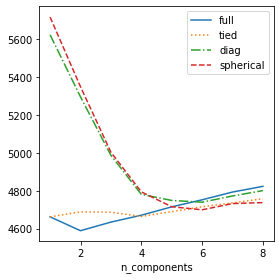

In [48]:
fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i], color=colors[i])

plt.tight_layout()
plt.show()

https://scikit-learn.org/stable/modules/mixture.html

## **7.5 Scaling and Categorical Variables**
### **7.5.1 Scaling the Variables**

In [49]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
loan_data

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,45338,Fully Paid,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,RENT,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,45339,Fully Paid,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,MORTGAGE,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,45340,Fully Paid,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,MORTGAGE,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,45341,Fully Paid,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,MORTGAGE,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [50]:
defaults = loan_data.loc[loan_data['outcome'] == 'default',]
defaults

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22666,22667,Charged Off,15250,60 months,45000,17.84,11.55790,960,32.0,debt_consolidation,RENT,0,1,7,3.0,default,3,debt_consolidation,RENT,> 1 Year,0.50
22667,22668,Charged Off,10000,36 months,50000,21.20,7.97040,2204,18.7,debt_consolidation,MORTGAGE,1,1,9,5.6,default,5,debt_consolidation,MORTGAGE,> 1 Year,0.60
22668,22669,Charged Off,25925,36 months,83000,9.60,12.03640,33314,53.9,credit_card,MORTGAGE,1,1,8,5.2,default,9,credit_card,MORTGAGE,> 1 Year,0.50
22669,22670,Charged Off,13375,36 months,43052,18.62,13.28970,9925,82.0,other,RENT,1,1,5,3.2,default,3,other,RENT,> 1 Year,0.50


In [51]:
columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
df

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util
0,2500,30000,1687,3,1.00,9.4
1,5600,40000,5210,11,5.55,32.6
2,5375,15000,9279,2,18.08,36.5
3,9000,30000,10452,4,10.08,91.7
4,10000,100000,11997,14,7.06,55.5
...,...,...,...,...,...,...
22666,15250,45000,960,7,17.84,32.0
22667,10000,50000,2204,9,21.20,18.7
22668,25925,83000,33314,8,9.60,53.9
22669,13375,43052,9925,5,18.62,82.0


In [52]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
# print(centers)
centers

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,18275.132345,83354.634595,19635.189254,11.664373,16.774586,62.258588,7543
1,21852.701005,165407.730318,38907.295645,12.597152,13.466876,63.634900,1194
2,10591.893792,42453.058692,10268.048598,9.583820,17.713563,58.111226,13882
3,22570.192308,489783.403846,85161.346154,13.326923,6.907500,59.651923,52


In [53]:
counts

Counter({0: 7543, 1: 1194, 2: 13882, 3: 52})

In [54]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns) # to go back to the original scale
centers['size'] = [counts[i] for i in range(4)]
# print(centers)
centers

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,10499.824632,51070.958451,11629.172535,7.511129,15.965747,77.806693,7405
1,10315.255666,53468.181307,6032.616033,8.637385,11.255855,31.000342,5339
2,25920.260952,116308.326663,32827.641428,12.389941,16.204021,66.172004,3701
3,13420.700048,55844.852918,16370.832021,14.334512,24.189881,59.227862,6226


In [55]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)    # after scaling
centers['size'] = [counts[i] for i in range(4)]
# print(centers)
centers

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,-0.392980,-0.304463,-0.177226,-0.621676,-0.154898,0.736299,7405
1,-0.415138,-0.246147,-0.465476,-0.382988,-0.769816,-1.176346,5339
2,1.458309,1.282523,0.914599,0.412290,-0.123789,0.260871,3701
3,-0.042316,-0.188331,0.066993,0.824403,0.918836,-0.022887,6226


### **7.5.2 Dominant Variables**

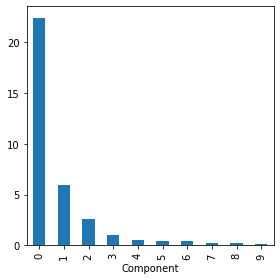

In [56]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [57]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
# print(loadings.transpose())
loadings.transpose()

,0,1
GOOGL,-0.857310,0.477873
AMZN,-0.444728,-0.874149
AAPL,-0.071627,-0.020802
MSFT,-0.036002,-0.006204
CSCO,-0.029205,-0.003045
INTC,-0.026666,-0.006069
CVX,-0.089548,-0.037420
XOM,-0.080336,-0.020511
SLB,-0.110218,-0.030356
COP,-0.057739,-0.024117


### **7.5.3 Categorical Data and Gower's Distance**
Currently not available in any of the standard packages. However, work is in progress to add it to scikit-learn. We will update this notebook once it becomes available.  
https://github.com/scikit-learn/scikit-learn/pull/9555/

In [58]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
# print(x)
x

,dti,payment_inc_ratio,home_,purpose_
0,1.00,2.39320,RENT,major_purchase
1,5.55,4.57170,OWN,small_business
2,18.08,9.71600,RENT,other
3,10.08,12.21520,RENT,debt_consolidation
4,7.06,3.90888,RENT,other


```
###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

### **7.5.4 Problems with Clustering Mixed Data**

In [59]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
# print(centers)
centers

,dti,payment_inc_ratio,pub_rec_zero,home__MORTGAGE,home__OWN,home__RENT
0,16.992128,9.105395,1.000000e+00,-2.298162e-14,-2.012279e-15,1.000000e+00
1,17.456244,8.422914,1.000000e+00,1.000000e+00,3.053113e-16,-1.304512e-14
2,16.504955,8.064247,2.009504e-14,5.156600e-01,-9.159340e-16,4.843400e-01
3,17.197993,9.266666,9.179025e-01,7.438494e-15,1.000000e+00,-5.273559e-15
